In [78]:
import pandas as pd
import tensorflow as tf
import numpy as np
import re

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt


In [79]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
df = pd.read_csv("depression_dataset.csv")

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [82]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


# Preprocessing

In [83]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

In [84]:
df['clean_text'] = df['clean_text'].apply(remove_stopwords)

In [85]:
df['clean_text']

0       understand people reply immediately op invitat...
1       welcome r depression check post place take mom...
2       anyone else instead sleeping depressed stay ni...
3       kind stuffed around lot life delaying inevitab...
4       sleep greatest comforting escape whenever wake...
                              ...                        
7726                                                 snow
7727                                 moulin rouge mad cry
7728                        trying shout find people list
7729    ughh find red sox hat got ta wear creepy nick ...
7730    slept wonderfully finally tried swatching new ...
Name: clean_text, Length: 7731, dtype: object

# Vectorization

In [86]:
X = df['clean_text'].values
y = df['is_depression'].values

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [88]:
MAX_LEN = 60
tokenizer = Tokenizer(num_words=MAX_LEN, oov_token='x')
tokenizer.fit_on_texts(X_train)

train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

In [89]:
X_train_seq = pad_sequences(train_sequence, padding='post', maxlen=MAX_LEN, truncating='post')
X_test_seq = pad_sequences(test_sequence, padding='post', maxlen=MAX_LEN, truncating='post')

# Modeling

In [90]:
model = Sequential([
    Embedding(len(tokenizer.word_index), 128, input_length=MAX_LEN),
    LSTM(32),
    Dense(36, activation='relu'),
    Dropout(0.5),
    Dense(24, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [91]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 60, 128)           2108928   
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_21 (Dense)            (None, 36)                1188      
                                                                 
 dropout_14 (Dropout)        (None, 36)                0         
                                                                 
 dense_22 (Dense)            (None, 24)                888       
                                                                 
 dropout_15 (Dropout)        (None, 24)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [92]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
class SelfCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
       if(logs.get('accuracy') > 0.956):      
          self.model.stop_training = True

In [95]:
history = model.fit(X_train_seq, y_train, epochs=50, validation_split=0.2, verbose=2, callbacks=[SelfCallback()])

Epoch 1/50
155/155 - 3s - loss: 0.4883 - accuracy: 0.7663 - val_loss: 0.3617 - val_accuracy: 0.8723 - 3s/epoch - 21ms/step
Epoch 2/50
155/155 - 1s - loss: 0.2964 - accuracy: 0.8977 - val_loss: 0.1756 - val_accuracy: 0.9458 - 1s/epoch - 7ms/step
Epoch 3/50
155/155 - 1s - loss: 0.1934 - accuracy: 0.9470 - val_loss: 0.1571 - val_accuracy: 0.9475 - 1s/epoch - 7ms/step
Epoch 4/50
155/155 - 1s - loss: 0.1830 - accuracy: 0.9472 - val_loss: 0.1641 - val_accuracy: 0.9426 - 1s/epoch - 7ms/step
Epoch 5/50
155/155 - 1s - loss: 0.1905 - accuracy: 0.9432 - val_loss: 0.1496 - val_accuracy: 0.9531 - 1s/epoch - 7ms/step
Epoch 6/50
155/155 - 1s - loss: 0.1743 - accuracy: 0.9499 - val_loss: 0.1599 - val_accuracy: 0.9466 - 1s/epoch - 7ms/step
Epoch 7/50
155/155 - 1s - loss: 0.1837 - accuracy: 0.9507 - val_loss: 0.2002 - val_accuracy: 0.9256 - 1s/epoch - 7ms/step
Epoch 8/50
155/155 - 1s - loss: 0.1841 - accuracy: 0.9483 - val_loss: 0.1522 - val_accuracy: 0.9491 - 1s/epoch - 7ms/step
Epoch 9/50
155/155 - 1s

In [97]:
evaluate = model.evaluate(X_test_seq, y_test)
evaluate[1]

49/49 [==============================] - 0s 4ms/step - loss: 0.1568 - accuracy: 0.9483


0.9482870101928711

# Plot

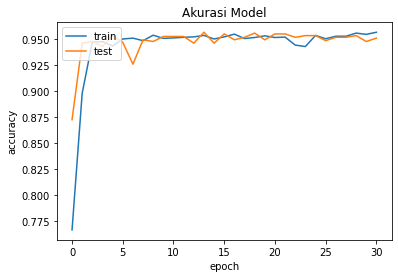

In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

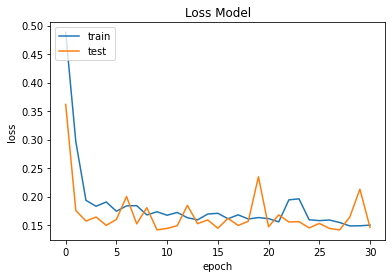

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()